# DS-2.2 Baseline modeling pt.2

## **Description:**

Time to create wonders!! We are finally ready to produce our first ML model to meet customer requirements:
- Create your feature extraction step in accordance with our validation schema
- Intergrate your extraction algo into your validation class to ensure data leakage absence
- Create several ML models: 
    - Linear regression, SVR, Random Forest, XGBoost and play with them, find the best model and make your first submission

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.dummy import DummyRegressor

import sys

sys.path.append("../")
from scripts.etl import transform_df_types
from scripts.validate import (
    TimeSeriesSplit,
    ModelTrainer,
)  # baseline_modeling.py module

# Load the train dataset with extracted features

In [2]:
train_df = pd.read_csv("../data/result_train.csv")

train_df = transform_df_types(train_df)
train_df.head(3)

,date_block_num,shop_id,item_id,item_cnt_month,item_price,month,year,item_name,item_category_id,item_category_name,...,item_cnt_month_cat_shop__lag_2,item_cnt_month_cat_shop__lag_3,days,avg_item_price,avg_item_price_lag_1,avg_item_price_lag_2,avg_item_price_lag_3,avg_item_price_lag_4,avg_item_price_lag_5,avg_item_price_lag_6
0,0.0,25.0,16257.0,1.0,148.0,0.0,0.0,Наушники RITMIX RH-124 Black,0.0,PC - Гарнитуры/Наушники,...,0.0,0.0,31.0,148.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,57.0,16255.0,1.0,93.0,1.0,0.0,Наушники PHILIPS SBC HC8680,0.0,PC - Гарнитуры/Наушники,...,0.0,0.0,28.0,93.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3.0,38.0,16256.0,1.0,22.4,3.0,0.0,Наушники RITMIX RH-120,0.0,PC - Гарнитуры/Наушники,...,0.0,0.0,30.0,22.4,0.0,0.0,0.0,0.0,0.0,0.0


# Clean train set from unneeded columns

In [3]:
train = train_df.select_dtypes(include=np.number)
y = train["item_cnt_month"]
X = train.drop(
    ["item_cnt_month", "item_price", "revenue", "avg_item_price", "month", "year"],
    axis=1,
    inplace=False,
)
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1608724 entries, 0 to 1608723
Data columns (total 36 columns):
 #   Column                          Non-Null Count    Dtype  
---  ------                          --------------    -----  
 0   date_block_num                  1608724 non-null  float32
 1   shop_id                         1608724 non-null  float32
 2   item_id                         1608724 non-null  float32
 3   item_category_id                1608724 non-null  float32
 4   months_since_last_sale          1608724 non-null  float32
 5   revenue_mean_on_shop_id         1608724 non-null  float32
 6   revenue_lag_1                   1608724 non-null  float32
 7   revenue_lag_2                   1608724 non-null  float32
 8   revenue_lag_3                   1608724 non-null  float32
 9   revenue_lag_6                   1608724 non-null  float32
 10  revenue_lag_12                  1608724 non-null  float32
 11  item_cnt_month_mean_on_item_id  1608724 non-null  float32
 12  

# Get train and test set for further model analysis

In [4]:
tscv = TimeSeriesSplit(n_splits=1, method="expanding")

for train_idx, test_idx in tscv.split(X):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    print(X_train.shape, y_train.shape)
    print(X_test.shape, y_test.shape)

(1577193, 36) (1577193,)
(31531, 36) (31531,)


In [5]:
sc = StandardScaler()
X_train_scaled = sc.fit_transform(X_train)
X_test_scaled = sc.transform(X_test)

# Define functions for plotting predictions

In [6]:
def model_performance_sc_plot(predictions, labels, title="Scatter Plot"):
    min_val = max(max(predictions), max(labels))
    max_val = min(min(predictions), min(labels))
    performance_df = pd.DataFrame({"Label": labels})
    performance_df["Prediction"] = predictions
    sns.jointplot(
        y="Label",
        x="Prediction",
        data=performance_df,
        kind="reg",
        height=7,
        color="blue",
        joint_kws={"scatter_kws": dict(alpha=0.05)},
    )
    plt.plot([min_val, max_val], [min_val, max_val], "m--")
    plt.suptitle(title, fontsize=16)
    plt.show()


def plot_residuals(y_true, y_pred, model_name="Model"):
    residuals = y_true - y_pred
    model_name = "Linear Regression model"
    _, axes = plt.subplots(1, 2, figsize=(12, 4))

    axes[0].scatter(y_pred, residuals, alpha=0.05)
    axes[0].axhline(0, color="red", linestyle="--")
    axes[0].set_xlabel("Predicted")
    axes[0].set_ylabel("Residuals")
    axes[0].set_title(f"{model_name} - Residual Plot")

    sns.histplot(residuals, color="red", ax=axes[1])
    axes[1].set_xlabel("Residuals")
    axes[1].set_title(f"{model_name} - Residual Distribution")
    plt.tight_layout()
    plt.show()


def plot_predictions_distribution(y_true, y_pred, histogram=False, model_name="Model"):
    plt.figure(figsize=(7, 5))

    if histogram:
        sns.histplot(y_test, bins=20, label=f"True target")
        sns.histplot(y_pred, bins=20, label=f"Predicted target")
        title = "Histograms"
    else:
        sns.kdeplot(y_test, label=f"True target", bw_adjust=1.5)
        sns.kdeplot(y_pred, label=f"Predicted target", bw_adjust=1.5)
        title = "Density plots"

    plt.title(f"{title} for {model_name}", fontsize=14)
    plt.xlabel("item_cnt_month", fontsize=12)
    plt.ylabel("Density", fontsize=12)
    plt.ylim(0, None)
    plt.xlim(0, 25)
    plt.xticks(range(-2, 22))
    plt.legend(title="Target sets", fontsize=10)
    plt.show()

# Dummy regressor

Use it as a **baseline model** to compare other models' performance with it

In [7]:
dummy_model = DummyRegressor(strategy="mean")
ModelTrainer.train_model(X, y, dummy_model)

1 split RMSE: 2.23

2 split RMSE: 2.03

3 split RMSE: 2.10

4 split RMSE: 2.56

5 split RMSE: 2.54

Average RMSE: 2.29


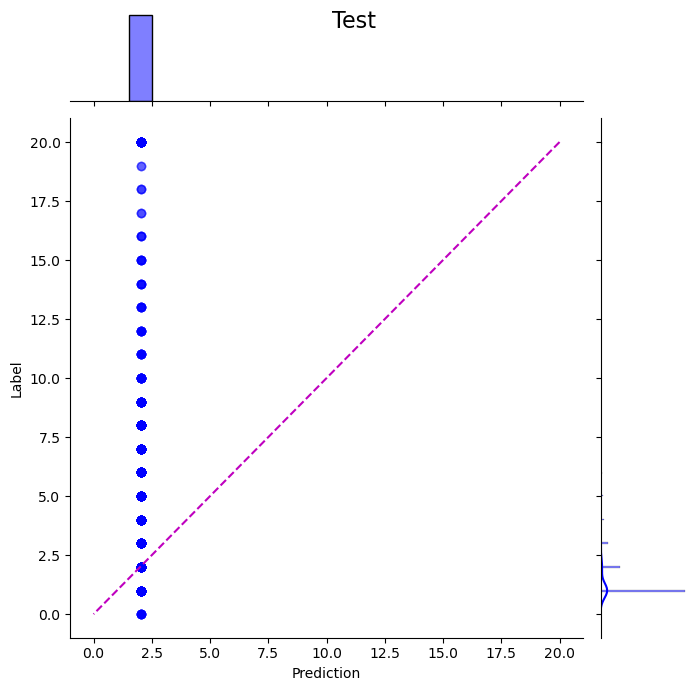

In [8]:
y_pred = dummy_model.predict(X_test)
model_performance_sc_plot(y_pred, y_test, "Test");

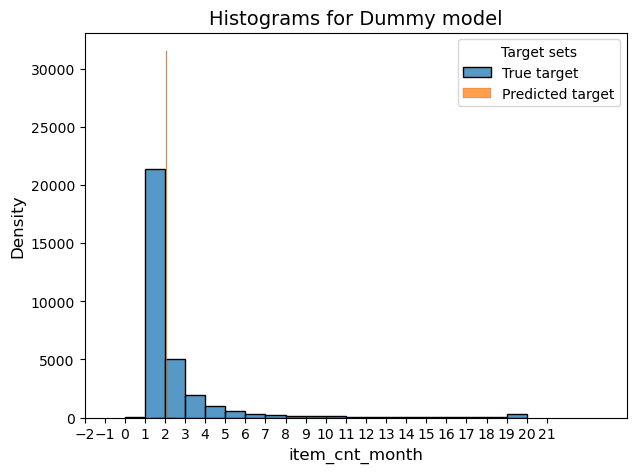

In [9]:
plot_predictions_distribution(y_test, y_pred, histogram=True, model_name="Dummy model")

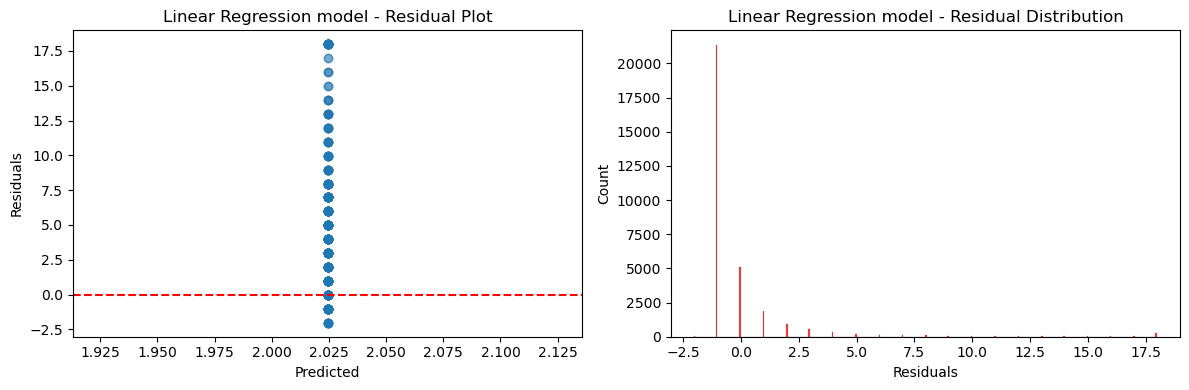

In [10]:
plot_residuals(y_test, y_pred, model_name="Dummy model")

# Linear regression

In [11]:
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error

In [12]:
lr = LinearRegression()
ModelTrainer.train_model(X, y, lr, apply_scaling=True)

1 split RMSE: 1.72

2 split RMSE: 1.55

3 split RMSE: 1.63

4 split RMSE: 2.08

5 split RMSE: 2.22

Average RMSE: 1.84


In [13]:
y_pred = lr.predict(X_test_scaled)
y_pred = y_pred.clip(0, 20)

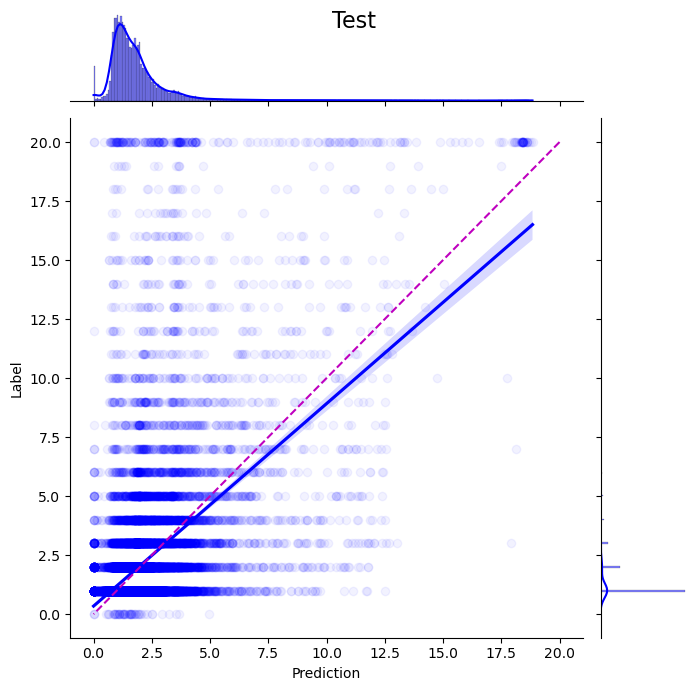

In [14]:
model_performance_sc_plot(y_pred, y_test, "Test")

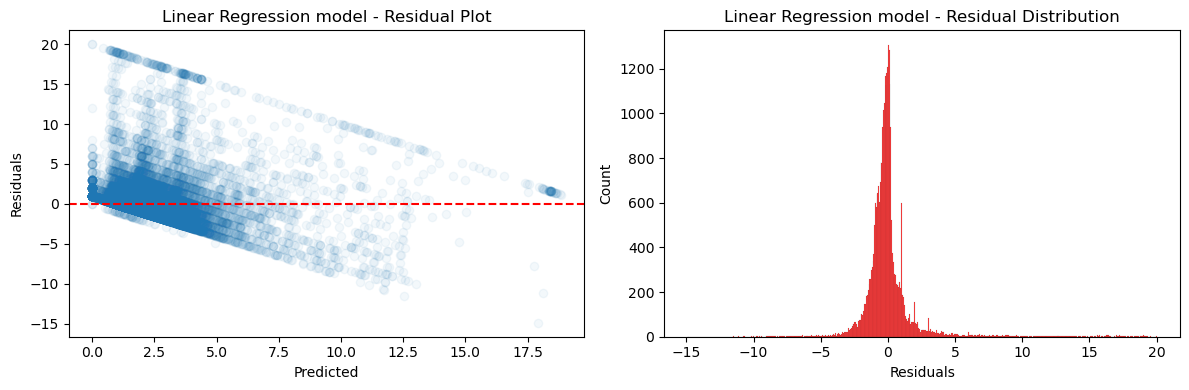

In [15]:
plot_residuals(y_test, y_pred, model_name="Linear Regression model")

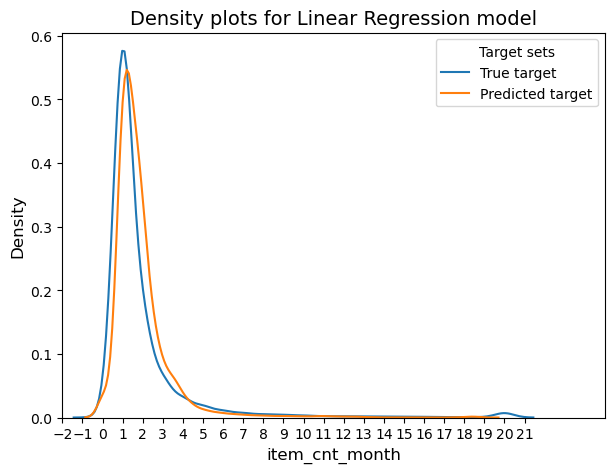

In [16]:
plot_predictions_distribution(y_test, y_pred, model_name="Linear Regression model")

# Support Vector Regression

In [17]:
from sklearn.svm import LinearSVR, SVR

In [18]:
tscv = TimeSeriesSplit(n_splits=1, method="expanding", train_start=12)

for train_idx, test_idx in tscv.split(X):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    print(X_train.shape, y_train.shape)
    print(X_test.shape, y_test.shape)

(889527, 36) (889527,)
(31531, 36) (31531,)


In [19]:
sc = StandardScaler()
X_train_scaled = sc.fit_transform(X_train)
X_test_scaled = sc.transform(X_test)

In [24]:
linear_svr = LinearSVR(dual="auto", max_iter=1500)
linear_svr.fit(X_train_scaled, y_train)

/home/alexennk/anaconda3/envs/ml/lib/python3.11/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVR(dual='auto', max_iter=1500)

In [25]:
y_pred = linear_svr.predict(X_test_scaled)
# y_pred = y_pred.clip(0, 20)
print(f"RMSE: {mean_squared_error(y_test, y_pred, squared=False)}")

RMSE: 2.329186746626005


/home/alexennk/anaconda3/envs/ml/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


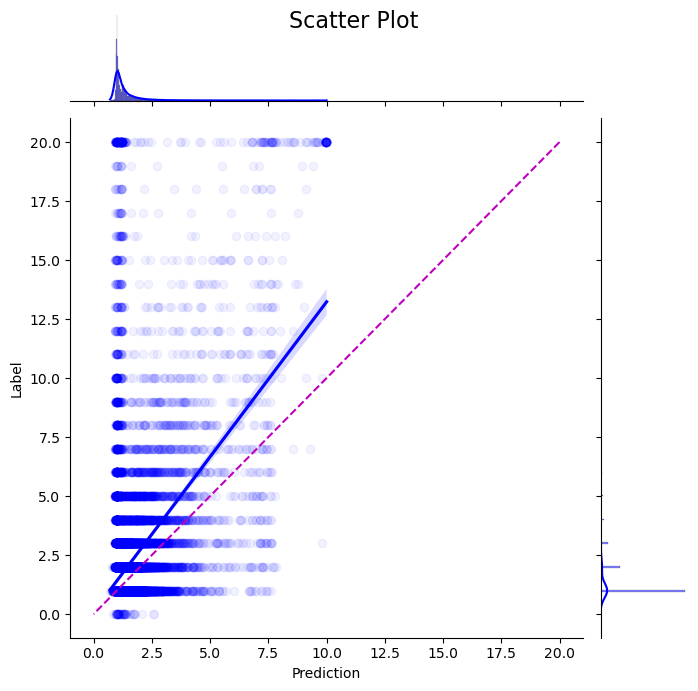

In [28]:
model_performance_sc_plot(y_pred, y_test)

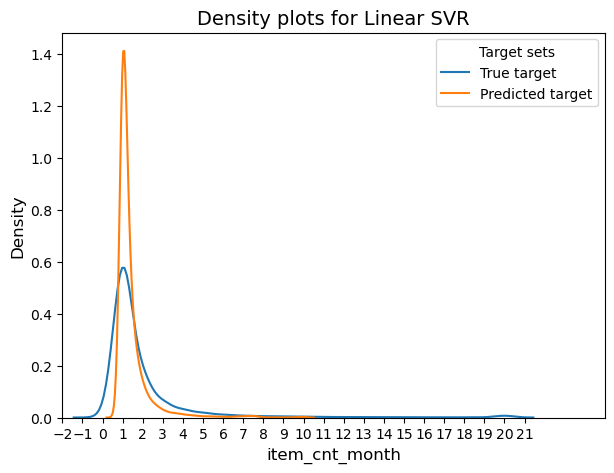

In [29]:
plot_predictions_distribution(y_test, y_pred, model_name="Linear SVR")

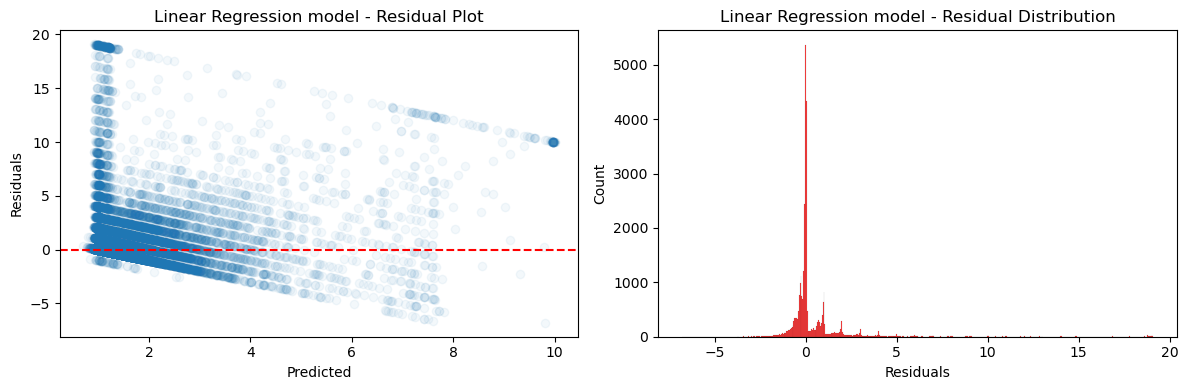

In [30]:
plot_residuals(y_test, y_pred, model_name="Linear SVR")

SVR required 9 minutes of training with linear kernel and 1 validation split..

In [20]:
X_train_for_rbf = X_train.copy()
X_train_for_rbf.info()

<class 'pandas.core.frame.DataFrame'>
Index: 889527 entries, 5704 to 1608621
Data columns (total 36 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   date_block_num                  889527 non-null  float32
 1   shop_id                         889527 non-null  float32
 2   item_id                         889527 non-null  float32
 3   item_category_id                889527 non-null  float32
 4   months_since_last_sale          889527 non-null  float32
 5   revenue_mean_on_shop_id         889527 non-null  float32
 6   revenue_lag_1                   889527 non-null  float32
 7   revenue_lag_2                   889527 non-null  float32
 8   revenue_lag_3                   889527 non-null  float32
 9   revenue_lag_6                   889527 non-null  float32
 10  revenue_lag_12                  889527 non-null  float32
 11  item_cnt_month_mean_on_item_id  889527 non-null  float32
 12  item_cnt_month_la

In [21]:
X_train_for_rbf.columns

Index(['date_block_num', 'shop_id', 'item_id', 'item_category_id',
       'months_since_last_sale', 'revenue_mean_on_shop_id', 'revenue_lag_1',
       'revenue_lag_2', 'revenue_lag_3', 'revenue_lag_6', 'revenue_lag_12',
       'item_cnt_month_mean_on_item_id', 'item_cnt_month_lag_1',
       'item_cnt_month_lag_2', 'item_cnt_month_lag_3', 'item_cnt_month_lag_6',
       'item_cnt_month_lag_12', 'item_cnt_month_date__lag_1',
       'item_cnt_month_date__lag_2', 'item_cnt_month_date__lag_3',
       'item_cnt_month_cat__lag_1', 'item_cnt_month_cat__lag_2',
       'item_cnt_month_cat__lag_3', 'item_cnt_month_item__lag_1',
       'item_cnt_month_item__lag_2', 'item_cnt_month_item__lag_3',
       'item_cnt_month_cat_shop__lag_1', 'item_cnt_month_cat_shop__lag_2',
       'item_cnt_month_cat_shop__lag_3', 'days', 'avg_item_price_lag_1',
       'avg_item_price_lag_2', 'avg_item_price_lag_3', 'avg_item_price_lag_4',
       'avg_item_price_lag_5', 'avg_item_price_lag_6'],
      dtype='object')

In [22]:
X_train_for_rbf = X_train_for_rbf[
    [
        "date_block_num",
        "shop_id",
        "item_id",
        "item_category_id",
        "months_since_last_sale",
        "revenue_mean_on_shop_id",
        "revenue_lag_1",
        "item_cnt_month_mean_on_item_id",
        "item_cnt_month_lag_1",
        "item_cnt_month_date__lag_1",
        "item_cnt_month_cat__lag_1",
        "item_cnt_month_item__lag_1",
        "avg_item_price_lag_1",
    ]
]

In [23]:
X_test_for_rbf = X_test[
    [
        "date_block_num",
        "shop_id",
        "item_id",
        "item_category_id",
        "months_since_last_sale",
        "revenue_mean_on_shop_id",
        "revenue_lag_1",
        "item_cnt_month_mean_on_item_id",
        "item_cnt_month_lag_1",
        "item_cnt_month_date__lag_1",
        "item_cnt_month_cat__lag_1",
        "item_cnt_month_item__lag_1",
        "avg_item_price_lag_1",
    ]
]

In [24]:
sc = StandardScaler()
X_train_scaled = sc.fit_transform(X_train_for_rbf)
X_test_scaled = sc.transform(X_test_for_rbf)

In [22]:
rbf_svr = SVR(kernel="rbf", verbose=True)
rbf_svr.fit(X_train_scaled[-100000:], y_train[-100000:])

[LibSVM]....................................................................*........................*
optimization finished, #iter = 92809
obj = -78994.623071, rho = -7.511858
nSV = 66349, nBSV = 64149


SVR(verbose=True)

In [23]:
pickle.dump(rbf_svr, open("../models/rbf_svr.pkl", "wb"))

In [24]:
rbf_svr = pickle.load(open("../models/rbf_svr.pkl", "rb"))

In [25]:
y_pred = rbf_svr.predict(X_test_scaled)

In [26]:
print(f"RMSE: {mean_squared_error(y_test, y_pred, squared=False)}")

RMSE: 2.199817345112014


/home/alexennk/anaconda3/envs/ml/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


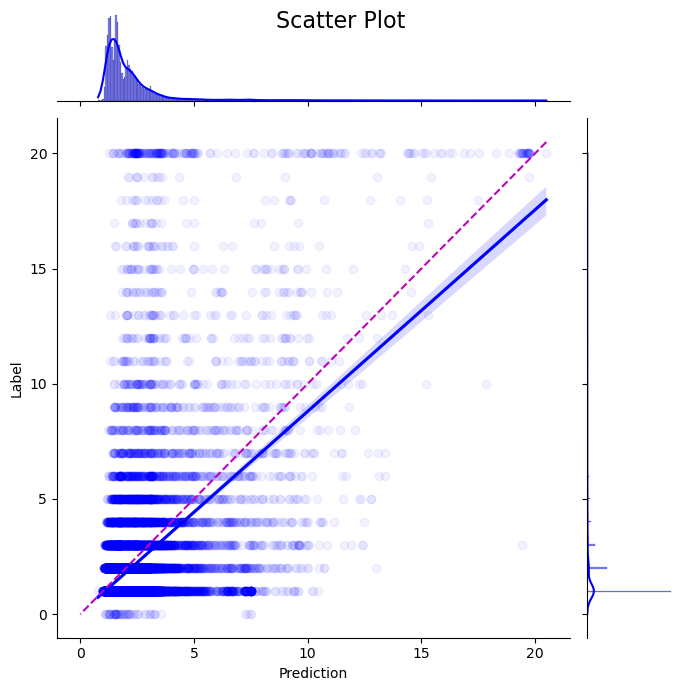

In [27]:
model_performance_sc_plot(y_pred, y_test)

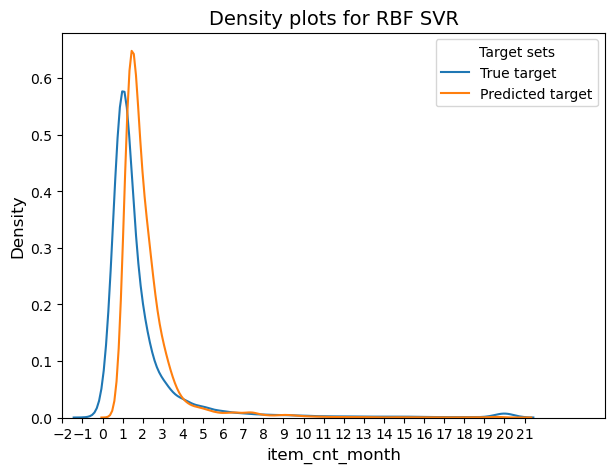

In [28]:
plot_predictions_distribution(y_test, y_pred, model_name="RBF SVR")

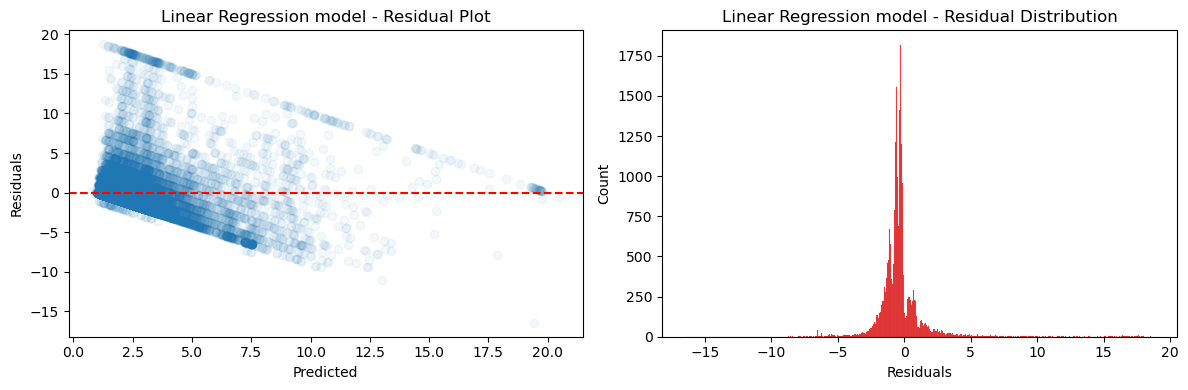

In [29]:
plot_residuals(y_test, y_pred, model_name="RBF SVR")

# Random Forest Regressor

In [30]:
from sklearn.ensemble import RandomForestRegressor

In [27]:
def train_rfr(
    X,
    y,
    max_depth=15,
    n_estimators=100,
    min_samples_leaf=5,
    random_state=42,
    scaler=StandardScaler(),
    cv_method="expanding",
    cv_n_splits=1,
    train_start=0,
    return_scores=False,
    return_model=False,
):
    """
    Returns on of these:
        - None
        - model
        - scores
        - model, scores
    """

    scores = []
    tscv = TimeSeriesSplit(
        n_splits=cv_n_splits, method=cv_method, train_start=train_start
    )

    for train_idx, test_idx in tscv.split(X):
        X_new = X.copy()
        X_new.drop("date_block_num", axis=1, inplace=True)
        X_train, X_test = X_new[train_idx], X_new[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        if scaler is not None:
            X_train = scaler.fit_transform(X_train)
            X_test = scaler.transform(X_test)

        model = RandomForestRegressor(
            n_estimators=n_estimators,
            max_depth=max_depth,
            min_samples_leaf=min_samples_leaf,
            random_state=random_state,
            n_jobs=-1,
        )

        model.fit(X_train, y_train)

        y_pred = model.predict(X_test)
        y_pred = y_pred.clip(0, 20)
        score = np.sqrt(mean_squared_error(y_test, y_pred))
        scores.append(score)

        print(f"{len(scores)} split RMSE: {score:.2f}\n")

    print(f"Average RMSE: {np.mean(scores):.2f}")

    if return_scores or return_model:
        to_return = []
        if return_model:
            to_return.append(model)
        if return_scores:
            to_return.append(scores)
        return tuple(to_return)

In [51]:
rfr = train_rfr(
    X,
    y,
    max_depth=17,
    n_estimators=100,
    min_samples_leaf=5,
    random_state=42,
    train_start=12,
    return_model=True,
)

1 split RMSE: 1.98

Average RMSE: 1.98


In [ ]:
pickle.dump(rfr[0], open("../models/rfr.pkl", "wb"))

In [28]:
rfr = pickle.load(open("../models/rfr.pkl", "rb"))

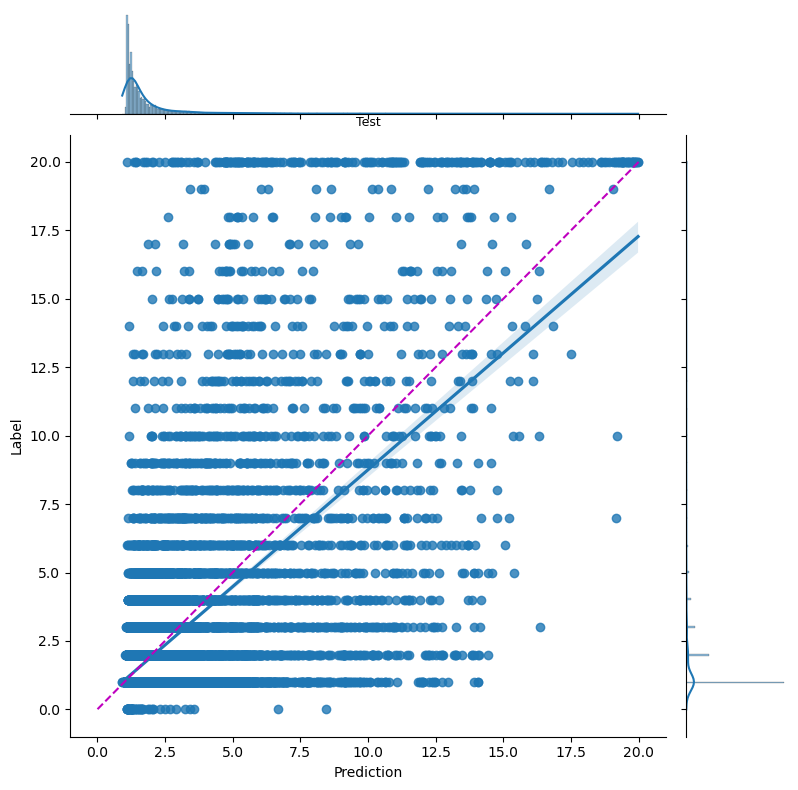

In [29]:
y_pred = rfr.predict(X_test_scaled)
y_pred = y_pred.clip(0, 20)
model_performance_sc_plot(y_pred, y_test, "Test")

# CatBoost

In [30]:
from catboost import CatBoostRegressor

In [46]:
def train_catboost(
    X,
    y,
    scaler=StandardScaler(),
    cv_method="expanding",
    cv_n_splits=5,
    train_start=0,
    return_scores=False,
    return_model=False,
):
    """
    Returns on of these:
        - None
        - model
        - scores
        - model, scores
    """

    scores = []
    tscv = TimeSeriesSplit(
        n_splits=cv_n_splits, method=cv_method, train_start=train_start
    )

    for train_idx, test_idx in tscv.split(X):
        X_new = X.copy()
        X_new.drop("date_block_num", axis=1, inplace=True)
        X_train, X_test = X_new[train_idx], X_new[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        if scaler is not None:
            X_train = scaler.fit_transform(X_train)
            X_test = scaler.transform(X_test)

        model = CatBoostRegressor(
            iterations=1000,
            max_ctr_complexity=10,
            random_seed=0,
            od_type="Iter",
            od_wait=25,
            verbose=50,
            depth=6,
            eval_metric="RMSE",
        )

        model.fit(X_train, y_train, eval_set=(X_test, y_test), plot=False)

        y_pred = model.predict(X_test)
        y_pred = y_pred.clip(0, 20)
        score = np.sqrt(mean_squared_error(y_test, y_pred))
        scores.append(score)

        print(f"{len(scores)} split RMSE: {score:.2f}\n")

    print(f"Average RMSE: {np.mean(scores):.2f}")

    if return_scores or return_model:
        to_return = []
        if return_model:
            to_return.append(model)
        if return_scores:
            to_return.append(scores)
        return tuple(to_return)

In [47]:
catboost_model = train_catboost(
    X, y, scaler=None, cv_n_splits=1, train_start=6, return_model=True
)

Learning rate set to 0.15552
0:	learn: 2.4556099	test: 2.4318139	best: 2.4318139 (0)	total: 74.1ms	remaining: 1m 13s
50:	learn: 1.8686655	test: 1.9443416	best: 1.9443263 (49)	total: 3.89s	remaining: 1m 12s
100:	learn: 1.8200954	test: 1.9236270	best: 1.9236270 (100)	total: 7.51s	remaining: 1m 6s
150:	learn: 1.7884006	test: 1.9216417	best: 1.9190523 (128)	total: 10.9s	remaining: 1m 1s
200:	learn: 1.7646995	test: 1.9131109	best: 1.9118121 (183)	total: 14.2s	remaining: 56.3s
Stopped by overfitting detector  (25 iterations wait)

bestTest = 1.911278833
bestIteration = 210

Shrink model to first 211 iterations.
1 split RMSE: 1.91

Average RMSE: 1.91


In [59]:
catboost_model[0].save_model("../models/catboost_model_untuned.cbm")

In [32]:
catboost_model = CatBoostRegressor()
catboost_model.load_model("../models/catboost_model_untuned.cbm")

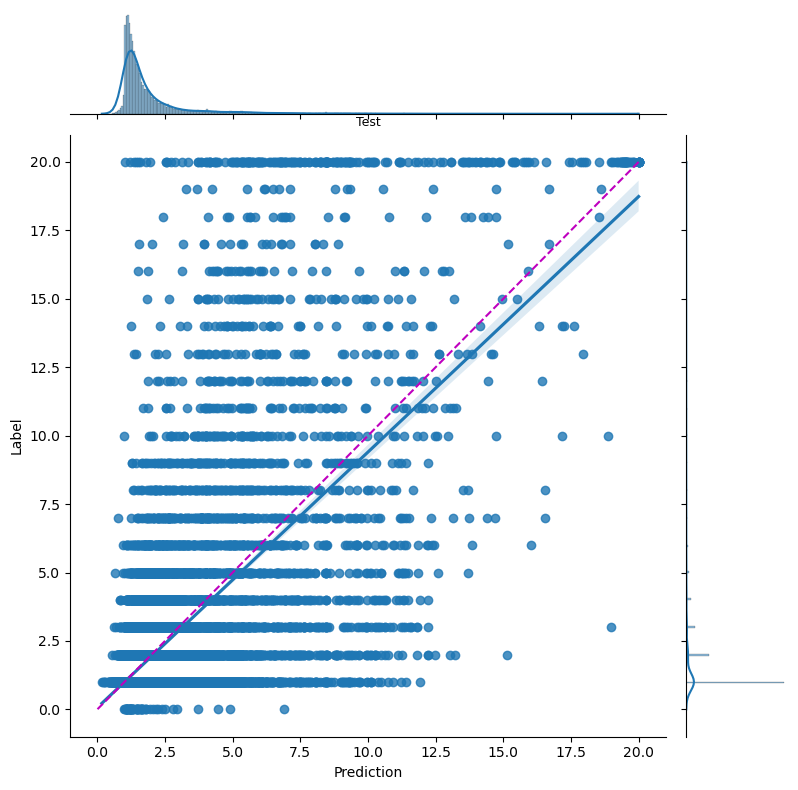

In [45]:
y_pred = catboost_model[0].predict(X_test)
y_pred = y_pred.clip(0, 20)
model_performance_sc_plot(y_pred, y_test, "Test")

In [34]:
catboost_model_12 = train_catboost(
    X, y, scaler=None, cv_n_splits=1, train_start=6, return_model=True
)

0:	learn: 2.5482727	test: 2.5030256	best: 2.5030256 (0)	total: 170ms	remaining: 4m 15s
1:	learn: 2.5049263	test: 2.4696574	best: 2.4696574 (1)	total: 281ms	remaining: 3m 30s
2:	learn: 2.4652784	test: 2.4405510	best: 2.4405510 (2)	total: 402ms	remaining: 3m 20s
3:	learn: 2.4284953	test: 2.4120998	best: 2.4120998 (3)	total: 548ms	remaining: 3m 25s
4:	learn: 2.3947121	test: 2.3871062	best: 2.3871062 (4)	total: 676ms	remaining: 3m 22s
5:	learn: 2.3633365	test: 2.3632417	best: 2.3632417 (5)	total: 791ms	remaining: 3m 16s
6:	learn: 2.3335477	test: 2.3408199	best: 2.3408199 (6)	total: 905ms	remaining: 3m 12s
7:	learn: 2.3065813	test: 2.3206677	best: 2.3206677 (7)	total: 1.02s	remaining: 3m 10s
8:	learn: 2.2817830	test: 2.3029771	best: 2.3029771 (8)	total: 1.13s	remaining: 3m 7s
9:	learn: 2.2583519	test: 2.2864253	best: 2.2864253 (9)	total: 1.2s	remaining: 2m 59s
10:	learn: 2.2360317	test: 2.2697641	best: 2.2697641 (10)	total: 1.27s	remaining: 2m 52s
11:	learn: 2.2158404	test: 2.2559824	best: 

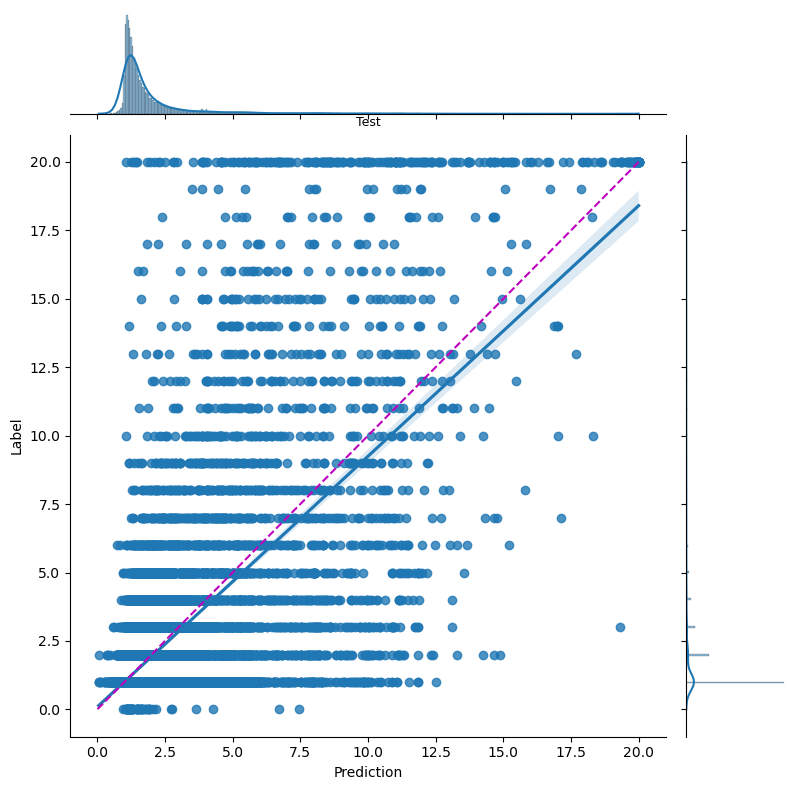

In [35]:
y_pred = catboost_model_12[0].predict(X_test)
y_pred = y_pred.clip(0, 20)
model_performance_sc_plot(y_pred, y_test, "Test")

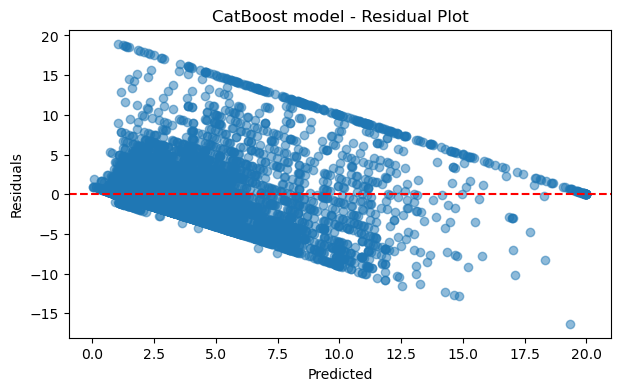

In [36]:
plot_residuals(y_test, y_pred, model_name="CatBoost model")

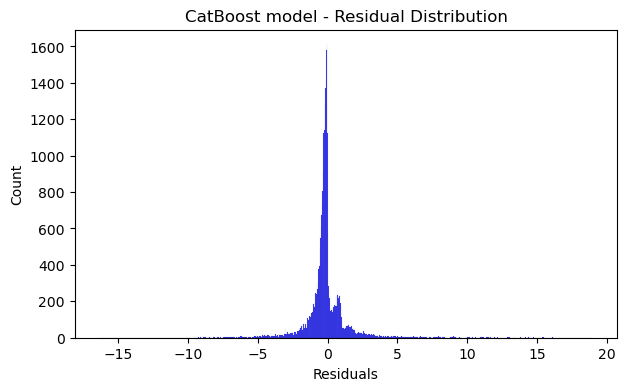

In [37]:
plot_residual_distribution(y_test, y_pred, model_name="CatBoost model")

In [38]:
eval_history = catboost_model_12[0].get_evals_result()

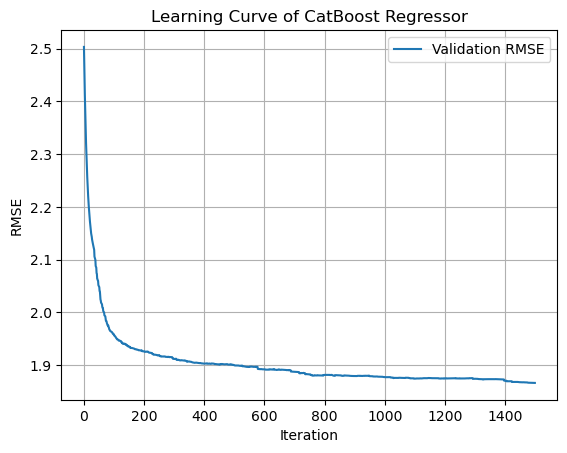

In [39]:
# Plot learning curve
plt.plot(eval_history["validation"]["RMSE"], label="Validation RMSE")
plt.xlabel("Iteration")
plt.ylabel("RMSE")
plt.title("Learning Curve of CatBoost Regressor")
plt.legend()
plt.grid()
plt.show()

### Negative residuals appear more often ==> the model tends to predict values that are bigger than in reality

# Function for creating submission

### Load the test set

In [17]:
test = pd.read_csv("../data/result_test.csv")
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214200 entries, 0 to 214199
Data columns (total 33 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   ID                              214200 non-null  int64  
 1   shop_id                         214200 non-null  int64  
 2   item_id                         214200 non-null  int64  
 3   item_name                       214200 non-null  object 
 4   item_category_id                214200 non-null  int64  
 5   item_category_name              214200 non-null  object 
 6   shop_name                       214200 non-null  object 
 7   months_since_last_sale          214200 non-null  int64  
 8   revenue_lag_1                   214200 non-null  float64
 9   revenue_lag_2                   214200 non-null  float64
 10  revenue_lag_3                   214200 non-null  float64
 11  revenue_lag_6                   214200 non-null  float64
 12  revenue_lag_12  

In [29]:
def get_submission(model, test, scaler=None, rounding=False, submission_tag=""):
    test_id = test["ID"]
    test = test.drop(["ID", "item_name", "shop_name", "item_category_name"], axis=1)

    if scaler is not None:
        test = scaler.transform(test)

    y_pred = model.predict(test)

    if rounding:
        y_pred = y_pred.round()

    y_pred = y_pred.clip(0, 20)

    submission = pd.DataFrame({"ID": test_id, "item_cnt_month": y_pred})
    submission.to_csv("submission_" + submission_tag + ".csv", index=False)